# SMAI Assignment 10

## Name - Akshat Maheshwari (20161024)

In [1]:
import numpy as np
import pandas as pd
import csv
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Question - 1 (Stock Price Prediction)

In [2]:
data = pd.read_csv('GoogleStocks.csv')
data = data.sort_values(by='date')

In [3]:
data.head()

,date,open,high,low,close,volume
754,2016/03/28,736.79,738.99,732.50,733.53,1300817
753,2016/03/29,734.59,747.25,728.76,744.77,1902254
752,2016/03/30,750.10,757.88,748.74,750.53,1782278
751,2016/03/31,749.25,750.85,740.94,744.95,1718638
750,2016/04/01,738.60,750.34,737.00,749.91,1576240


In [4]:
def extract_features(dataset):
    open_prices = np.array(dataset['open'])
    close_prices = np.array(dataset['close'])
    high_prices = np.array(dataset['high'])
    low_prices = np.array(dataset['low'])
    volumes = np.array(dataset['volume'])
    
    avg_prices = np.mean([high_prices, low_prices], axis=0)
    
    dataset['Avg_Price'] = avg_prices
    
    return dataset

In [5]:
def train_test_spl(dataset):
    train_set, test_set = train_test_split(dataset, shuffle=False)
    
    return train_set, test_set

In [6]:
modified_dataset = extract_features(data)
train_set, test_set = train_test_spl(modified_dataset)

In [7]:
# modified_dataset = extract_features(train_set)
feature_vec = train_set.iloc[:, -2:].values
print(feature_vec)

[[1.30081700e+06 7.35745000e+02]
 [1.90225400e+06 7.38005000e+02]
 [1.78227800e+06 7.53310000e+02]
 ...
 [1.64824800e+06 1.17772280e+03]
 [1.23235200e+06 1.16476350e+03]
 [1.31016400e+06 1.15487825e+03]]


### RNN - LSTM Model

In [8]:
sc = MinMaxScaler(feature_range = (0, 1))
feature_vec_scaled = sc.fit_transform(feature_vec)

sc_target = MinMaxScaler(feature_range = (0, 1))
open_vals = train_set.iloc[:, 1:2].values
feature_vec_target = sc_target.fit_transform(open_vals)

print(feature_vec_scaled.shape)
print(feature_vec_target.shape)

(566, 2)
(566, 1)


In [11]:
real_stock_prices = test_set.iloc[:, 1:2].values

In [19]:
time_step_list = [20, 50, 75]
hidden_layers_list = [30, 50, 80]

### For 2 Hidden Layers

In [33]:
def hid_layers_2_model(feature_vec_scaled, feature_vec_target, hid_layer_size, time_steps):
    print("Hidden Layer Size =", hid_layer_size)
    print("Time Steps =", time_steps)
    X_train = []
    y_train = []
    for i in range(time_steps, len(train_set)):
        X_train.append(feature_vec_scaled[i-time_steps:i])
        y_train.append(feature_vec_target[i])
    X_train, y_train = np.array(X_train), np.array(y_train)


#     print(X_train.shape, y_train.shape)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*2, 1))
#     print(X_train.shape, y_train.shape)
    
    regressor = Sequential()

    regressor.add(LSTM(units = hid_layer_size, return_sequences = True, input_shape = (X_train.shape[1], 1)))

    regressor.add(LSTM(units = hid_layer_size))

    regressor.add(Dense(units = 1))

    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

    regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
    
    dataset_total = modified_dataset.iloc[:, -2:]
    inputs = dataset_total[len(dataset_total) - len(test_set) - time_steps:].values
    inputs = inputs.reshape(-1,2)
    inputs = sc.transform(inputs)
    X_test = []
    for i in range(time_steps, len(test_set)+time_steps):
        X_test.append(inputs[i-time_steps:i])
    X_test = np.array(X_test)

    print(X_test.shape)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*2, 1))
    predicted_stock_price = regressor.predict(X_test)
    predicted_stock_price = sc_target.inverse_transform(predicted_stock_price)
    
    plt.plot(real_stock_prices, color = 'black', label = 'Google Stock Price')
    plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Google Stock Price')
    plt.title('Google Stock Price Prediction \n Hidden Layers=%d, Time Steps=%d' % (hid_layer_size, time_step))
    plt.xlabel('Time')
    plt.ylabel('Google Stock Price')
    plt.legend()
    plt.show()

Hidden Layer Size = 30
Time Steps = 20
Epoch 1/100
546/546 [==============================] - 3s 6ms/step - loss: 0.1035
Epoch 2/100
546/546 [==============================] - 1s 923us/step - loss: 0.0278
Epoch 3/100
546/546 [==============================] - 1s 960us/step - loss: 0.0177
Epoch 4/100
546/546 [==============================] - 1s 951us/step - loss: 0.0129
Epoch 5/100
546/546 [==============================] - 0s 908us/step - loss: 0.0111
Epoch 6/100
546/546 [==============================] - 1s 982us/step - loss: 0.0114
Epoch 7/100
546/546 [==============================] - 1s 998us/step - loss: 0.0093
Epoch 8/100
546/546 [==============================] - 1s 954us/step - loss: 0.0107
Epoch 9/100
546/546 [==============================] - 1s 943us/step - loss: 0.0093
Epoch 10/100
546/546 [==============================] - 1s 941us/step - loss: 0.0088
Epoch 11/100
546/546 [==============================] - 1s 943us/step - loss: 0.0095
Epoch 12/100
546/546 [===============

Epoch 98/100
546/546 [==============================] - 1s 1ms/step - loss: 4.8953e-04
Epoch 99/100
546/546 [==============================] - 1s 1ms/step - loss: 4.7294e-04
Epoch 100/100
546/546 [==============================] - 1s 1ms/step - loss: 3.5413e-04
(189, 20, 2)


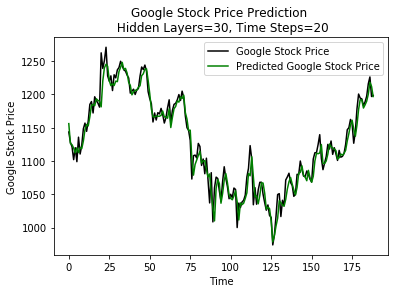

Hidden Layer Size = 50
Time Steps = 20
Epoch 1/100
546/546 [==============================] - 3s 6ms/step - loss: 0.1006
Epoch 2/100
546/546 [==============================] - 1s 930us/step - loss: 0.0270
Epoch 3/100
546/546 [==============================] - 1s 945us/step - loss: 0.0156
Epoch 4/100
546/546 [==============================] - 0s 915us/step - loss: 0.0105
Epoch 5/100
546/546 [==============================] - 1s 926us/step - loss: 0.0100
Epoch 6/100
546/546 [==============================] - 1s 997us/step - loss: 0.0096
Epoch 7/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0092
Epoch 8/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0091
Epoch 9/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0091
Epoch 10/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0084
Epoch 11/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0082
Epoch 12/100
546/546 [=========================

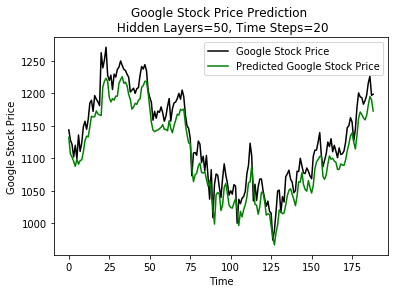

Hidden Layer Size = 80
Time Steps = 20
Epoch 1/100
546/546 [==============================] - 4s 6ms/step - loss: 0.0971
Epoch 2/100
546/546 [==============================] - 1s 993us/step - loss: 0.0216
Epoch 3/100
546/546 [==============================] - 1s 972us/step - loss: 0.0138
Epoch 4/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0102
Epoch 5/100
546/546 [==============================] - 1s 971us/step - loss: 0.0103
Epoch 6/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0095
Epoch 7/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0103
Epoch 8/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0089
Epoch 9/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0095
Epoch 10/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0094
Epoch 11/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0079
Epoch 12/100
546/546 [=============================

Epoch 97/100
546/546 [==============================] - 1s 1ms/step - loss: 3.4755e-04
Epoch 98/100
546/546 [==============================] - 1s 1ms/step - loss: 4.7252e-04
Epoch 99/100
546/546 [==============================] - 1s 1ms/step - loss: 3.9811e-04
Epoch 100/100
546/546 [==============================] - 1s 1ms/step - loss: 3.7892e-04
(189, 20, 2)


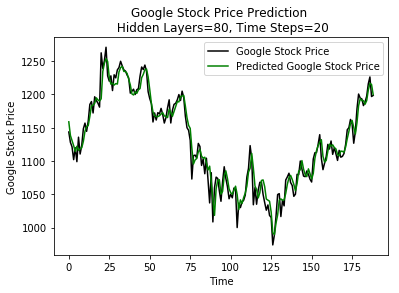

Hidden Layer Size = 30
Time Steps = 50
Epoch 1/100
516/516 [==============================] - 4s 8ms/step - loss: 0.1537
Epoch 2/100
516/516 [==============================] - 1s 2ms/step - loss: 0.0279
Epoch 3/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0180
Epoch 4/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0123
Epoch 5/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0096
Epoch 6/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0092
Epoch 7/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0095
Epoch 8/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0090
Epoch 9/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0105
Epoch 10/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0084
Epoch 11/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0085
Epoch 12/100
516/516 [==============================] - 1

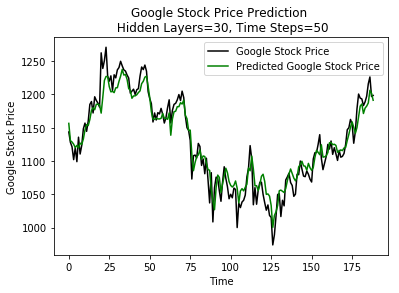

Hidden Layer Size = 50
Time Steps = 50
Epoch 1/100
516/516 [==============================] - 5s 10ms/step - loss: 0.0977
Epoch 2/100
516/516 [==============================] - 1s 2ms/step - loss: 0.0197
Epoch 3/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0136
Epoch 4/100
516/516 [==============================] - 2s 3ms/step - loss: 0.0096
Epoch 5/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0089
Epoch 6/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0091
Epoch 7/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0087
Epoch 8/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0082
Epoch 9/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0081
Epoch 10/100
516/516 [==============================] - 2s 3ms/step - loss: 0.0077
Epoch 11/100
516/516 [==============================] - 2s 3ms/step - loss: 0.0075
Epoch 12/100
516/516 [==============================] - 

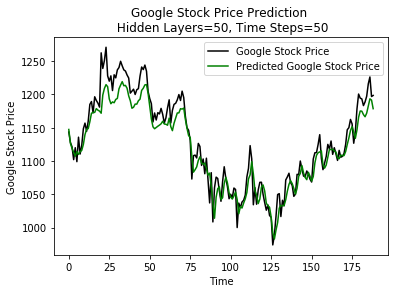

Hidden Layer Size = 80
Time Steps = 50
Epoch 1/100
516/516 [==============================] - 5s 10ms/step - loss: 0.0731
Epoch 2/100
516/516 [==============================] - 2s 3ms/step - loss: 0.0158
Epoch 3/100
516/516 [==============================] - 2s 3ms/step - loss: 0.0111
Epoch 4/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0103
Epoch 5/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0091
Epoch 6/100
516/516 [==============================] - 2s 3ms/step - loss: 0.0091
Epoch 7/100
516/516 [==============================] - 2s 3ms/step - loss: 0.0096
Epoch 8/100
516/516 [==============================] - 2s 3ms/step - loss: 0.0080
Epoch 9/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0082
Epoch 10/100
516/516 [==============================] - 2s 3ms/step - loss: 0.0082
Epoch 11/100
516/516 [==============================] - 2s 3ms/step - loss: 0.0088
Epoch 12/100
516/516 [==============================] - 

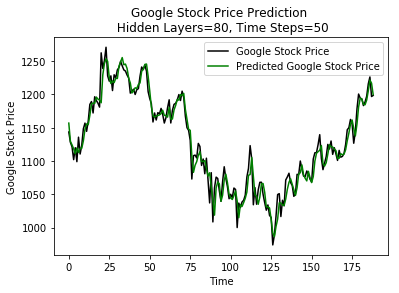

Hidden Layer Size = 30
Time Steps = 75
Epoch 1/100
491/491 [==============================] - 5s 10ms/step - loss: 0.1470
Epoch 2/100
491/491 [==============================] - 2s 3ms/step - loss: 0.0298
Epoch 3/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0178
Epoch 4/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0129
Epoch 5/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0098
Epoch 6/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0090
Epoch 7/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0090
Epoch 8/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0088
Epoch 9/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0092
Epoch 10/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0083
Epoch 11/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0083
Epoch 12/100
491/491 [==============================] - 

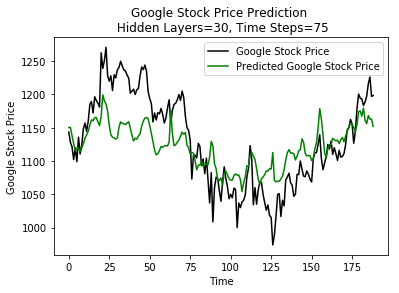

Hidden Layer Size = 50
Time Steps = 75
Epoch 1/100
491/491 [==============================] - 5s 11ms/step - loss: 0.0996
Epoch 2/100
491/491 [==============================] - 2s 3ms/step - loss: 0.0207
Epoch 3/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0143
Epoch 4/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0104
Epoch 5/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0092
Epoch 6/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0099
Epoch 7/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0092
Epoch 8/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0088
Epoch 9/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0082
Epoch 10/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0082
Epoch 11/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0081
Epoch 12/100
491/491 [==============================] - 

491/491 [==============================] - 2s 4ms/step - loss: 3.6860e-04
Epoch 99/100
491/491 [==============================] - 2s 4ms/step - loss: 3.8650e-04
Epoch 100/100
491/491 [==============================] - 2s 4ms/step - loss: 4.0023e-04
(189, 75, 2)


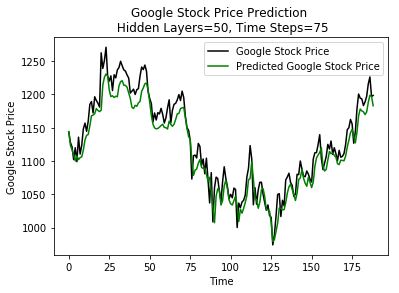

Hidden Layer Size = 80
Time Steps = 75
Epoch 1/100
491/491 [==============================] - 5s 11ms/step - loss: 0.1093
Epoch 2/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0202
Epoch 3/100
491/491 [==============================] - 2s 5ms/step - loss: 0.0125
Epoch 4/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0092
Epoch 5/100
491/491 [==============================] - 2s 5ms/step - loss: 0.0089
Epoch 6/100
491/491 [==============================] - 2s 5ms/step - loss: 0.0099
Epoch 7/100
491/491 [==============================] - 2s 5ms/step - loss: 0.0100
Epoch 8/100
491/491 [==============================] - 2s 5ms/step - loss: 0.0083
Epoch 9/100
491/491 [==============================] - 2s 5ms/step - loss: 0.0079
Epoch 10/100
491/491 [==============================] - 2s 4ms/step - loss: 0.0079
Epoch 11/100
491/491 [==============================] - 2s 5ms/step - loss: 0.0077
Epoch 12/100
491/491 [==============================] - 

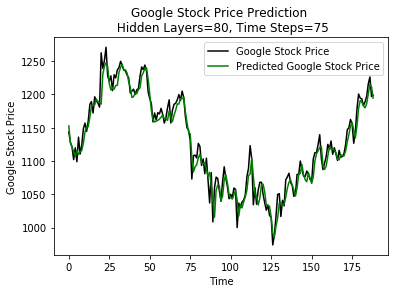

In [34]:
for time_step in time_step_list:
    for hidden_layers in hidden_layers_list:
        hid_layers_2_model(feature_vec_scaled, feature_vec_target, hidden_layers, time_step)

### For 3 Hidden Layers

In [35]:
def hid_layers_3_model(feature_vec_scaled, feature_vec_target, hid_layer_size, time_steps):
    print("Hidden Layer Size =", hid_layer_size)
    print("Time Steps =", time_steps)
    X_train = []
    y_train = []
    for i in range(time_steps, len(train_set)):
        X_train.append(feature_vec_scaled[i-time_steps:i])
        y_train.append(feature_vec_target[i])
    X_train, y_train = np.array(X_train), np.array(y_train)


#     print(X_train.shape, y_train.shape)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*2, 1))
#     print(X_train.shape, y_train.shape)
    
    regressor = Sequential()

    regressor.add(LSTM(units = hid_layer_size, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    
    regressor.add(LSTM(units = hid_layer_size, return_sequences = True))

    regressor.add(LSTM(units = hid_layer_size))

    regressor.add(Dense(units = 1))

    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

    regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
    
    dataset_total = modified_dataset.iloc[:, -2:]
    inputs = dataset_total[len(dataset_total) - len(test_set) - time_steps:].values
    inputs = inputs.reshape(-1,2)
    inputs = sc.transform(inputs)
    X_test = []
    for i in range(time_steps, len(test_set)+time_steps):
        X_test.append(inputs[i-time_steps:i])
    X_test = np.array(X_test)

    # print(X_test.shape)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*2, 1))
    predicted_stock_price = regressor.predict(X_test)
    predicted_stock_price = sc_target.inverse_transform(predicted_stock_price)
    
    plt.plot(real_stock_prices, color = 'black', label = 'Google Stock Price')
    plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Google Stock Price')
    plt.title('Google Stock Price Prediction \n Hidden Layers=%d, Time Steps=%d' % (hid_layer_size, time_step))
    plt.xlabel('Time')
    plt.ylabel('Google Stock Price')
    plt.legend()
    plt.show()

Hidden Layer Size = 30
Time Steps = 20
Epoch 1/100
546/546 [==============================] - 5s 9ms/step - loss: 0.1377
Epoch 2/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0322
Epoch 3/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0182
Epoch 4/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0122
Epoch 5/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0111
Epoch 6/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0106
Epoch 7/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0119
Epoch 8/100
546/546 [==============================] - 1s 2ms/step - loss: 0.0149
Epoch 9/100
546/546 [==============================] - 1s 2ms/step - loss: 0.0104
Epoch 10/100
546/546 [==============================] - 1s 2ms/step - loss: 0.0099
Epoch 11/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0091
Epoch 12/100
546/546 [==============================] - 1

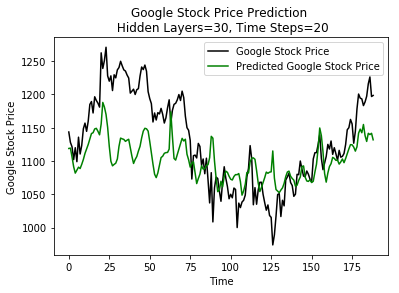

Hidden Layer Size = 50
Time Steps = 20
Epoch 1/100
546/546 [==============================] - 5s 10ms/step - loss: 0.1077
Epoch 2/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0265
Epoch 3/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0130
Epoch 4/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0109
Epoch 5/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0108
Epoch 6/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0101
Epoch 7/100
546/546 [==============================] - 1s 2ms/step - loss: 0.0097
Epoch 8/100
546/546 [==============================] - 1s 2ms/step - loss: 0.0093
Epoch 9/100
546/546 [==============================] - 1s 2ms/step - loss: 0.0091
Epoch 10/100
546/546 [==============================] - 1s 2ms/step - loss: 0.0089
Epoch 11/100
546/546 [==============================] - 1s 2ms/step - loss: 0.0089
Epoch 12/100
546/546 [==============================] - 

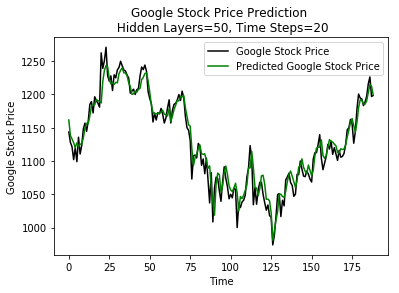

Hidden Layer Size = 80
Time Steps = 20
Epoch 1/100
546/546 [==============================] - 6s 10ms/step - loss: 0.0724
Epoch 2/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0171
Epoch 3/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0109
Epoch 4/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0110
Epoch 5/100
546/546 [==============================] - 1s 1ms/step - loss: 0.0101
Epoch 6/100
546/546 [==============================] - 1s 2ms/step - loss: 0.0105
Epoch 7/100
546/546 [==============================] - 1s 2ms/step - loss: 0.0122
Epoch 8/100
546/546 [==============================] - 1s 2ms/step - loss: 0.0094
Epoch 9/100
546/546 [==============================] - 1s 2ms/step - loss: 0.0102
Epoch 10/100
546/546 [==============================] - 1s 2ms/step - loss: 0.0100
Epoch 11/100
546/546 [==============================] - 1s 2ms/step - loss: 0.0094
Epoch 12/100
546/546 [==============================] - 

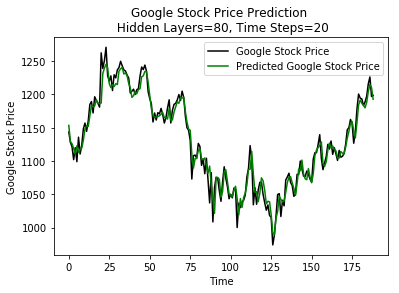

Hidden Layer Size = 30
Time Steps = 50
Epoch 1/100
516/516 [==============================] - 7s 13ms/step - loss: 0.1107
Epoch 2/100
516/516 [==============================] - 2s 3ms/step - loss: 0.0303
Epoch 3/100
516/516 [==============================] - 2s 3ms/step - loss: 0.0194
Epoch 4/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0107
Epoch 5/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0091
Epoch 6/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0089
Epoch 7/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0087
Epoch 8/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0086
Epoch 9/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0084
Epoch 10/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0086
Epoch 11/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0092
Epoch 12/100
516/516 [==============================] - 

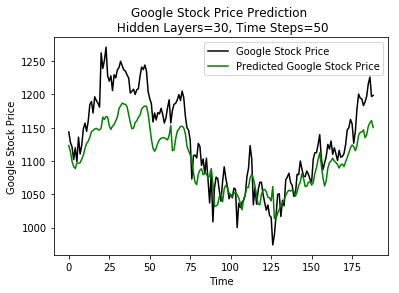

Hidden Layer Size = 50
Time Steps = 50
Epoch 1/100
516/516 [==============================] - 7s 14ms/step - loss: 0.1137
Epoch 2/100
516/516 [==============================] - 2s 3ms/step - loss: 0.0221
Epoch 3/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0131
Epoch 4/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0108
Epoch 5/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0106
Epoch 6/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0113
Epoch 7/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0093
Epoch 8/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0087
Epoch 9/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0095
Epoch 10/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0087
Epoch 11/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0084
Epoch 12/100
516/516 [==============================] - 

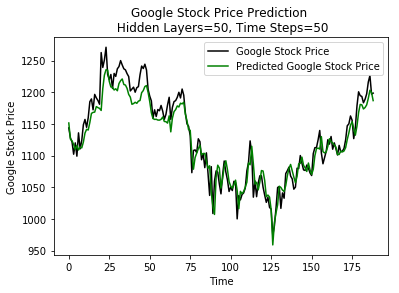

Hidden Layer Size = 80
Time Steps = 50
Epoch 1/100
516/516 [==============================] - 7s 14ms/step - loss: 0.0877
Epoch 2/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0206
Epoch 3/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0111
Epoch 4/100
516/516 [==============================] - 2s 5ms/step - loss: 0.0094
Epoch 5/100
516/516 [==============================] - 2s 5ms/step - loss: 0.0095
Epoch 6/100
516/516 [==============================] - 2s 5ms/step - loss: 0.0094
Epoch 7/100
516/516 [==============================] - 2s 5ms/step - loss: 0.0085
Epoch 8/100
516/516 [==============================] - 2s 5ms/step - loss: 0.0095
Epoch 9/100
516/516 [==============================] - 2s 5ms/step - loss: 0.0086
Epoch 10/100
516/516 [==============================] - 2s 5ms/step - loss: 0.0095
Epoch 11/100
516/516 [==============================] - 2s 5ms/step - loss: 0.0086
Epoch 12/100
516/516 [==============================] - 

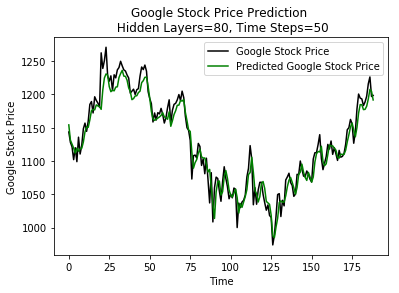

Hidden Layer Size = 30
Time Steps = 75
Epoch 1/100
491/491 [==============================] - 8s 16ms/step - loss: 0.1505
Epoch 2/100
491/491 [==============================] - 2s 5ms/step - loss: 0.0362
Epoch 3/100
491/491 [==============================] - 3s 6ms/step - loss: 0.0200
Epoch 4/100
491/491 [==============================] - 3s 6ms/step - loss: 0.0127
Epoch 5/100
491/491 [==============================] - 3s 6ms/step - loss: 0.0096
Epoch 6/100
491/491 [==============================] - 3s 6ms/step - loss: 0.0098
Epoch 7/100
491/491 [==============================] - 3s 6ms/step - loss: 0.0101
Epoch 8/100
491/491 [==============================] - 3s 6ms/step - loss: 0.0088
Epoch 9/100
491/491 [==============================] - 3s 6ms/step - loss: 0.0086
Epoch 10/100
491/491 [==============================] - 3s 6ms/step - loss: 0.0090
Epoch 11/100
491/491 [==============================] - 3s 6ms/step - loss: 0.0085
Epoch 12/100
491/491 [==============================] - 

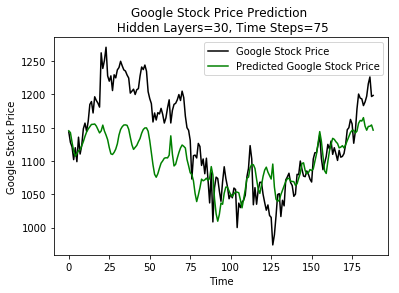

Hidden Layer Size = 50
Time Steps = 75
Epoch 1/100
491/491 [==============================] - 14s 29ms/step - loss: 0.0926
Epoch 2/100
491/491 [==============================] - 5s 11ms/step - loss: 0.0274
Epoch 3/100
491/491 [==============================] - 6s 11ms/step - loss: 0.0154
Epoch 4/100
491/491 [==============================] - 5s 11ms/step - loss: 0.0115
Epoch 5/100
491/491 [==============================] - 5s 11ms/step - loss: 0.0110
Epoch 6/100
491/491 [==============================] - 5s 11ms/step - loss: 0.0097
Epoch 7/100
491/491 [==============================] - 5s 11ms/step - loss: 0.0088
Epoch 8/100
491/491 [==============================] - 5s 11ms/step - loss: 0.0092
Epoch 9/100
491/491 [==============================] - 5s 11ms/step - loss: 0.0090
Epoch 10/100
491/491 [==============================] - 5s 11ms/step - loss: 0.0093
Epoch 11/100
491/491 [==============================] - 5s 11ms/step - loss: 0.0085
Epoch 12/100
491/491 [=======================

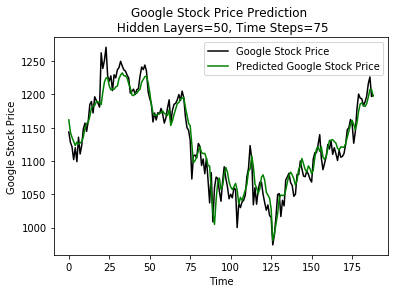

Hidden Layer Size = 80
Time Steps = 75
Epoch 1/100
491/491 [==============================] - 16s 33ms/step - loss: 0.0864
Epoch 2/100
491/491 [==============================] - 5s 11ms/step - loss: 0.0187
Epoch 3/100
491/491 [==============================] - 5s 11ms/step - loss: 0.0112
Epoch 4/100
491/491 [==============================] - 5s 11ms/step - loss: 0.0098
Epoch 5/100
491/491 [==============================] - 6s 11ms/step - loss: 0.0092
Epoch 6/100
491/491 [==============================] - 5s 11ms/step - loss: 0.0091
Epoch 7/100
491/491 [==============================] - 5s 11ms/step - loss: 0.0084
Epoch 8/100
491/491 [==============================] - 5s 11ms/step - loss: 0.0085
Epoch 9/100
491/491 [==============================] - 5s 11ms/step - loss: 0.0083
Epoch 10/100
491/491 [==============================] - 5s 11ms/step - loss: 0.0082
Epoch 11/100
491/491 [==============================] - 5s 11ms/step - loss: 0.0085
Epoch 12/100
491/491 [=======================

491/491 [==============================] - 6s 12ms/step - loss: 9.4783e-04
Epoch 99/100
491/491 [==============================] - 6s 11ms/step - loss: 9.6246e-04
Epoch 100/100
491/491 [==============================] - 7s 14ms/step - loss: 8.5321e-04


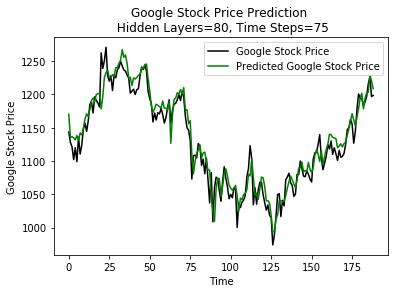

In [36]:
for time_step in time_step_list:
    for hidden_layers in hidden_layers_list:
        hid_layers_3_model(feature_vec_scaled, feature_vec_target, hidden_layers, time_step)

## Question - 2 (DNA Sequence)

In [37]:
inp_seq = 'CTTCATGTGAAAGCAGACGTAAGTCA'
state_path_seq = 'EEEEEEEEEEEEEEEEEE5IIIIIII'

state_change_prob = [[0.9, 0.1, 0], [0, 0, 1.0], [0, 0, 0.9]]
cond_prob = [[0.25, 0.25, 0.25, 0.25], [0.05, 0, 0.95, 0], [0.4, 0.1, 0.1, 0.4]]

print(len(inp_seq))
print(len(state_path_seq))

26
26


In [39]:
def check_ind(a):
    if a=='A':
        return 0
    elif a=='C':
        return 1
    elif a=='G':
        return 2
    elif a=='T':
        return 3

In [42]:
def check_ind1(a):
    if a=='E':
        return 0
    elif a=='5':
        return 1
    elif a=='I':
        return 2

In [53]:
import math

probability = 1.0 * cond_prob[check_ind1(state_path_seq[0])][check_ind(inp_seq[0])]

# print(probability)
log_probabs = []

log_probabs.append(math.log(probability))

for i in range(1, len(inp_seq)):
    probability *= (state_change_prob[check_ind1(state_path_seq[i-1])][check_ind1(state_path_seq[i])] * cond_prob[check_ind1(state_path_seq[i])][check_ind(inp_seq[i])])
    log_probabs.append(math.log(probability))
#     if state_path_seq[i]=='5':
#         print(math.log(probability))
    
probability *= 0.1

log_probability = math.log(probability)

log_probabs.append(log_probability)

print(log_probabs)

print("Final Log Probability =", log_probability)

[-1.3862943611198906, -2.8779492378976075, -4.369604114675324, -5.861258991453041, -7.352913868230758, -8.844568745008475, -10.336223621786193, -11.827878498563908, -13.319533375341626, -14.811188252119342, -16.30284312889706, -17.794498005674775, -19.286152882452495, -20.77780775923021, -22.269462636007926, -23.761117512785646, -25.25277238956336, -26.744427266341077, -29.098305653722672, -30.01459638559683, -31.03624763312881, -32.057898880660794, -34.465844489312666, -35.48749573684464, -37.895441345496515, -38.9170925930285, -41.21967768602254]
Final Log Probability = -41.21967768602254
